In [33]:
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 13.0 MB/s eta 0:00:00a 0:00:01


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import scipy.stats as stats

# Implemented methods
methods = ['DynProg', 'ValIter']

# Some colours
LIGHT_RED    = '#FFC4CC'
LIGHT_GREEN  = '#95FD99'
BLACK        = '#000000'
WHITE        = '#FFFFFF'
LIGHT_PURPLE = '#E8D0FF'
LIGHT_ORANGE = '#FAE0C3'

In [386]:

import random


class Maze:

    # Actions
    STAY       = 0
    MOVE_LEFT  = 1
    MOVE_RIGHT = 2
    MOVE_UP    = 3
    MOVE_DOWN  = 4

    # Give names to actions
    actions_names = {
        STAY: "stay",
        MOVE_LEFT: "move left",
        MOVE_RIGHT: "move right",
        MOVE_UP: "move up",
        MOVE_DOWN: "move down"
    }

    # Reward values
    
    STEP_REWARD = 0         #TODO
    GOAL_REWARD = 100         #TODO
    IMPOSSIBLE_REWARD =  0  #TODO
    LOSS_REWARD = -50      #TODO


    def __init__(self, maze, allow_minotaur_stay, restart, restart_state):
        """ Constructor of the environment Maze.
        """
        self.maze                     = maze
        #self.key_position             = (0,7)
        self.start_position           = ((0,0), (6,5))
        self.restart                  = restart
        self.allow_minotaur_stay      = allow_minotaur_stay
        self.actions                  = self.__actions()
        self.states, self.map         = self.__states()
        self.restart_state            = restart_state
        self.n_actions                = len(self.actions)
        self.n_states                 = len(self.states)
        self.possible_actions         = self.__possible_actions()
        self.moves_cache = dict()
        
        

    def __actions(self):
        actions = dict()
        actions[self.STAY]       = (0, 0)
        actions[self.MOVE_LEFT]  = (0,-1)
        actions[self.MOVE_RIGHT] = (0, 1)
        actions[self.MOVE_UP]    = (-1,0)
        actions[self.MOVE_DOWN]  = (1,0)
        return actions

    def __states(self):
        states = dict()
        map = dict()
        s = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                if self.maze[i,j] != 1:  # Agent cannot be in a wall
                    for k in range(self.maze.shape[0]):
                        for l in range(self.maze.shape[1]):
                            # Remove the condition self.maze[k,l] != 1
                            #for has_key in [False, True]:
                            states[s] = ((i, j), (k, l))
                            map[((i, j), (k, l))] = s
                            s += 1
        return states, map

    def __move_minotaur(self, state, actions_minotaur, pick_random): 
        
        if not pick_random: 
            if np.random.rand() < 0.35: 
                    actions_minotaur = []
                    mx, my = self.states[state][1][0], self.states[state][1][1]
                    ax, ay = self.states[state][0][0], self.states[state][0][1]
                    if ax > mx:
                        actions_minotaur.append('RIGHT')
                    elif ax < mx:
                        actions_minotaur.append('LEFT')
                    if ay > my:
                        actions_minotaur.append('DOWN')
                    elif ay < my:
                        actions_minotaur.append('UP')
                    if not actions_minotaur:
                        actions_minotaur = ['UP', 'DOWN', 'LEFT', 'RIGHT']
                    
        rows_minotaur, cols_minotaur = [], []
        for i in range(len(actions_minotaur)):
            # Is the minotaur getting out of the limits of the maze?
            impossible_action_minotaur = (self.states[state][1][0] + actions_minotaur[i][0] == -1) or \
                                            (self.states[state][1][0] + actions_minotaur[i][0] == self.maze.shape[0]) or \
                                            (self.states[state][1][1] + actions_minotaur[i][1] == -1) or \
                                            (self.states[state][1][1] + actions_minotaur[i][1] == self.maze.shape[1])
            if not impossible_action_minotaur:
                rows_minotaur.append(self.states[state][1][0] + actions_minotaur[i][0])
                cols_minotaur.append(self.states[state][1][1] + actions_minotaur[i][1]) 
                
        return rows_minotaur, cols_minotaur

    def __move(self, state, action, pick_random = True):
        """ Makes a step in the maze, given a current position and an action. 
            If the action STAY or an inadmissible action is used, the player stays in place.
        
            :return list of tuples next_state: Possible states ((x,y), (x',y')) on the maze that the system can transition to.
        """
        current_state = self.states[state]
        exit_pos = (np.where(self.maze == 2)[0][0], np.where(self.maze == 2)[1][0])
        agent_pos = current_state[0]
        minotaur_pos = current_state[1]
        #has_key = current_state[2]
        if self.restart and agent_pos == minotaur_pos:
            return [self.restart_state], False
        if agent_pos == exit_pos: 
            return [current_state], False
        else: 
            
            row_player = agent_pos[0] + self.actions[action][0] # Row of the player's next position 
            col_player = agent_pos[1] + self.actions[action][1] 
            # Is the player getting out of the limits of the maze or hitting a wall?
            impossible_action_player =  (row_player < 0 or row_player >= self.maze.shape[0] or 
                                col_player < 0 or col_player >= self.maze.shape[1] or 
                                (self.maze[row_player, col_player] == 1) # Check if the position is a wall
            )
            
            actions_minotaur = [[0, -1], [0, 1], [-1, 0], [1, 0]] # Possible moves for the Minotaur
           
            if self.allow_minotaur_stay:
                actions_minotaur.append([0, 0])
                
            rows_minotaur, cols_minotaur = self.__move_minotaur(state, actions_minotaur, pick_random)
            
            if impossible_action_player:
                new_agent_pos = agent_pos  # Stay in place
            else:
                new_agent_pos = (row_player, col_player)

            # Update has_key if agent reaches the key position
            #if new_agent_pos == self.key_position:
                #has_key = True

            # Minotaur's movement
            rows_minotaur, cols_minotaur = self.__move_minotaur(state, actions_minotaur, pick_random)

            # Generate possible next states
            next_states = []
            for i in range(len(rows_minotaur)):
                new_minotaur_pos = (rows_minotaur[i], cols_minotaur[i])

                # Check if agent is caught by minotaur
                if new_agent_pos == new_minotaur_pos:
                    return [self.restart_state], False
                else:
                    # Check if agent dies from poison
                    """if np.random.rand() < (1/50):  # 2% chance to die each step
                        next_states.append('Dead')
                    else:"""
                    # Check if agent reaches exit with key
                    """if new_agent_pos == exit_pos and has_key:
                        next_states.append('Win')
                    else:"""
                    next_state = (new_agent_pos, new_minotaur_pos)
                    next_states.append(next_state)
            return next_states, impossible_action_player


    def rewards(self, state, possible):
        exit_pos = (np.where(self.maze == 2)[0][0], np.where(self.maze == 2)[1][0])        
        agent_pos = state[0]
        minotaur_pos = state[1]
        #has_key = state[2]
        #if has_key == True: 
         #   print("found key")
        """ Computes the rewards for every state-action pair """
        reward = 0 
        if agent_pos == minotaur_pos: 
            print("in loss")
            reward += self.LOSS_REWARD
        elif agent_pos == (6, 5): 
            print("in win")
            reward += self.GOAL_REWARD
        if not possible: 
            print("impossible")
            return (reward + self.IMPOSSIBLE_REWARD)
        else: 
            return reward 
    
    def __possible_actions(self):
        """
        build a dictionary of possible actions at each state
        """
        possible_actions = dict()
        for s_index, state in self.states.items():
            list_states = []
            for a, a_delta in self.actions.items():
                new_state = tuple(map(sum, zip(state[0], a_delta)))
                if all(0 <= new_state[i] < self.maze.shape[i] for i in range(len(new_state))):
                    list_states.append(a)

            possible_actions[s_index] = list_states

        return possible_actions
    
    def step(self, state, action):
        """ Executes one time step within the environment.

            :param int state: Current state index.
            :param int action: Action index taken by the agent.
            :return: next_state (int), reward (float), done (bool)
        """
        # Get the list of possible next states
        next_states, impossible = self.__move(state, action)
        
        # Randomly select one next state (due to minotaur's randomness)
        random_index = random.randint(0, len(next_states) - 1)
        next_state_info = next_states[random_index]

        next_state_index = self.map[next_state_info]
        # Get the reward for the current state and action
        reward = self.rewards(next_state_info, impossible)
        print("reward in step: ", reward)
        return next_state_index, reward

    def simulate(self, start, policy, method):
        if method not in methods:
            error = 'ERROR: the argument method must be in {}'.format(methods)
            raise NameError(error)

        path = list()
        
            
        if method == "QLearning":
            t = 0  # Initialize current time
            s = self.map[start]
            path.append(start)
            while True:
                # Include poison probability
                if np.random.rand() < 1/50:
                    path.append('Dead')
                    break

                a = policy[s]  # Action from Q-learning policy
                next_states = self.__move(s, a)
                random_number = random.randint(0, len(next_states) - 1)
                next_s = next_states[random_number]
                path.append(next_s)
                if next_s in ['Win', 'Eaten', 'Dead']:
                    break
                s = self.map[next_s]
                t += 1
            horizon = t

        return [path, horizon] 

    
    
    

In [161]:
def get_actions(env, state_index, epsilon, Q, only_possible = True): 
    """
    selects an action from the possible actions at state s.
    :param s: current state
    :param eps: exploration rate.
    :param Q: current estimation of rewards (table of dimension S*A)
    :return: selected action a
    """
    if np.random.rand() < epsilon:
        # select an action for exploration.
        if only_possible:
            temp = random.choice(env.possible_actions[state_index])
        else:
            temp = random.randrange(env.n_actions)
    else:
        # Exploit: best action from Q-table
        temp = np.argmax(Q[state_index, :])
    return temp

In [384]:
def get_action(env, s_index, eps, Q, only_possible = True):
        """
        selects an action from the possible actions at state s.
        :param s: current state
        :param eps: exploration rate.
        :param Q: current estimation of rewards (table of dimension S*A)
        :return: selected action a
        """
        rand = np.random.uniform()
        if rand < eps:
            # select an action for exploration.
            if only_possible:
                random_number = random.randint(0,len(env.possible_actions[s_index])-1)
                return env.possible_actions[s_index][random_number]
            else:
                random_number = random.randint(0,len(env.n_actions[s_index])-1)
                return env.n_actions[s_index][random_number]
        else:
            # select an action for exploitation
            return np.argmax(Q[s_index, :])

In [355]:
def within(position, bounds):
    """
    Check if a position is within the bounds of the maze.
    
    Args:
        position (tuple): The position to check (e.g., (x, y)).
        bounds (tuple): The shape of the maze (e.g., (width, height)).
    
    Returns:
        bool: True if the position is within the bounds, False otherwise.
    """
    return all(0 <= position[i] < bounds[i] for i in range(len(position)))

In [390]:
def walls(position, maze): 
    return (maze[position[0], position[1]] == 1) 

In [388]:
def moves(env, state, action):
        """ Makes a step in the city, given a current position and an action.
            If the action STAY or an inadmissible action is used, the agent stays in place.

            :return next state index and corresponding transition prob.
        """

        # cache
        
        current_state = state # env.states[state]
        exit_pos = (np.where(env.maze == 2)[0][0], np.where(env.maze == 2)[1][0])
        agent_pos = current_state[0]
        minotaur_pos = current_state[1]
        cached = env.moves_cache.get((state, action), None)
        
        if cached is not None:
            return cached

        if env.restart and agent_pos == minotaur_pos:
            return [(env.restart_state, env.rewards(env.restart_state, True))]

        # Compute the future position given current (state, action)
        #new_player_pos = agent_pos + env.actions[action]
        row_player = agent_pos[0] + env.actions[action][0] # Row of the player's next position 
        col_player = agent_pos[1] + env.actions[action][1] 
        new_player_pos = (row_player, col_player)
        if (new_player_pos == (6, 5)):
            print("should be exit!")
        # Is the future position possible?
        move_possible = within(new_player_pos, env.maze.shape)
        move_possible = not walls(new_player_pos, env.maze)
        # If we can't move, we stay
        if not move_possible:
            new_player_pos = agent_pos

        if not env.allow_minotaur_stay:
            minotaur_move = [(0, -1), (0, 1), (-1, 0), (1, 0)]
        else:
            minotaur_move = [(0,0), (0, -1), (0, 1), (-1, 0), (1, 0)]

            #print("Actions: {}".format(list(map(str, police_actions))))

        next_states = []
        # keep on picking a new move as long as the chosen move is impossible
        for min_action in minotaur_move:
            #new_minotaur = minotaur_pos + min_action
            row_min = minotaur_pos[0] + min_action[0] # Row of the player's next position 
            col_min = minotaur_pos[1] + min_action[1] 
            new_minotaur = (row_min, col_min)
            if within(new_minotaur, env.maze.shape):
                next_s = (new_player_pos, new_minotaur)
                next_states.append((next_s, env.rewards(next_s, move_possible)))

        env.moves_cache[(state, action)] = next_states

        return next_states

def move(env, state, action):
    print(action)
    
    next_s, reward = random.choice(moves(env, state, action))

    return next_s, reward

In [225]:
def compute_lr(t):
    """
    A learning rate scheduler that guarantees convergence
    since sum_t(lr_t) = inf & sum_t(lr_t^2) < inf
    :param t: the current iteration of the Q-learning / SARSA algorithm
    :return: the current learning rate
    """
    # start at t+1 to avoid division by 0
    return 1/((t+1)**(2/3))

In [378]:
def q_learning(env, gamma, epsilon, episodes, alpha_exponent=2/3):
    """ Solves the maze problem using episodic Q-learning with ε-greedy policy.
        :input Maze env           : The maze environment.
        :input float gamma        : The discount factor.
        :input float epsilon      : Exploration rate for the ε-greedy policy.
        :input int episodes       : Number of episodes to run.
        :return numpy.array Q     : Learned Q-values for state-action pairs.
        :return numpy.array policy: Derived policy from the learned Q-values.
    """
    # Number of states and actions
    n_states = env.n_states
    n_actions = env.n_actions
    Q = np.zeros((n_states, n_actions))
    n = np.zeros((n_states, n_actions)) # number of updates to Q at each point

    s = env.restart_state
    init_s_index = env.map[s]

    V_t = [] 
    print(env.map)

    # Loop over episodes
    for t in range(episodes):
        V_t.append(np.max(Q[init_s_index, :]))

        s_index = env.map[s]
        a = get_action(env, s_index, epsilon, Q)

        s_next, curr_reward = move(env, s, a)
        print(curr_reward)
        s_next_index = env.map[s_next]
    
        lr = compute_lr(n[s_index, a])
        # print(Q[s_next_index, :])
        best_next_Q = np.max(Q[s_next_index, :])
        print(best_next_Q)
        Q[s_index, a] = (1-lr)*Q[s_index, a] + lr*(curr_reward + gamma*best_next_Q)
        n[s_index, a] += 1
        """
        if curr_reward != 0:
            print("updated Q of this s: ", Q[s_index,:], "the updated value is: ", Q[s_index, a])
        """
        s = s_next

    return Q, V_t

If the minotaur is not allowed to stand still, it is never possible that the player is caught by the minotaur. This is because the minotaur will always be in an even location at an even value of t and in an odd location at each odd value of t. (where t starts at 0 (=even) and an even location is defined as the sum of the x-value and y-value is even e.g. (4,6) = 10 = even).

The player starts at an even location and will just wait one step, then take one step at each timestep and thus always avoid the minotaur, since the player will be in an even location when the minotaur is in an odd location and vice versa.

h) 
Agent's Limited Life Due to Poison:
Since the agent's life is now geometrically distributed with a mean of 50, the probability of surviving each time step is  $p_{\text{survive}} = 1 - \frac{1}{50} = 0.98$. This means there’s a 2% chance the agent dies from poison at each step.
Similar to exercise e) we include the probability that the agent dies from poison after taking an action with the discount factor gamma. The minotaur now moves towards the agent with a 35\% probability and moves randomly with a 65\% probability. This means we need to update the transition function as now the moves are no longer purely random. Therefore we first need to determin which movements are towards the agent and which are not. To determine which movements are towards the agent we take the actions which minimizes the Manhattan distance to the agent. If multiple actions equally reduce the distance, the minotaur selects among them uniformly at random. With a 65% probability, the minotaur moves uniformly at random to any adjacent cell, possibly moving through walls. These constraints can be realized by changing the code in the simulate function. Here we now consider: 
\begin{equation}
next_states = self.__move(s, a)
next_states_towards = towards_agent(next_states, s)
next_states_away = away_agent(next_states_towards, next_states)
next_s = select_s(next_states_towards, 0.35, next_states_away, 0.65)
path.append(next_s)
\end{equation}

The new requirement to optain a key first requires us to change the state space to include a binary variable indicating whether the agent has the keys (has_keys). ach state is now represented as  $s = (\text{agent\_position}, \text{minotaur\_position}, \text{has\_keys})$.
Because acquiring the keys does not require a separate action; it occurs upon entering position C, we do not need to modify the action space. 
The policy must first guide the agent towards position C to acquire the keys. Therefore, we need to adapt the reward function to only assign a possitiv reward on successful exit only when has_keys is true.


# Bonus 
i) episodic Q-leanring algorithm using $\epsilon$ greedy policy


In [258]:
print(env.maze.shape)

(7, 8)


{((0, 0), (0, 0)): 0, ((0, 0), (0, 1)): 1, ((0, 0), (0, 2)): 2, ((0, 0), (0, 3)): 3, ((0, 0), (0, 4)): 4, ((0, 0), (0, 5)): 5, ((0, 0), (0, 6)): 6, ((0, 0), (0, 7)): 7, ((0, 0), (1, 0)): 8, ((0, 0), (1, 1)): 9, ((0, 0), (1, 2)): 10, ((0, 0), (1, 3)): 11, ((0, 0), (1, 4)): 12, ((0, 0), (1, 5)): 13, ((0, 0), (1, 6)): 14, ((0, 0), (1, 7)): 15, ((0, 0), (2, 0)): 16, ((0, 0), (2, 1)): 17, ((0, 0), (2, 2)): 18, ((0, 0), (2, 3)): 19, ((0, 0), (2, 4)): 20, ((0, 0), (2, 5)): 21, ((0, 0), (2, 6)): 22, ((0, 0), (2, 7)): 23, ((0, 0), (3, 0)): 24, ((0, 0), (3, 1)): 25, ((0, 0), (3, 2)): 26, ((0, 0), (3, 3)): 27, ((0, 0), (3, 4)): 28, ((0, 0), (3, 5)): 29, ((0, 0), (3, 6)): 30, ((0, 0), (3, 7)): 31, ((0, 0), (4, 0)): 32, ((0, 0), (4, 1)): 33, ((0, 0), (4, 2)): 34, ((0, 0), (4, 3)): 35, ((0, 0), (4, 4)): 36, ((0, 0), (4, 5)): 37, ((0, 0), (4, 6)): 38, ((0, 0), (4, 7)): 39, ((0, 0), (5, 0)): 40, ((0, 0), (5, 1)): 41, ((0, 0), (5, 2)): 42, ((0, 0), (5, 3)): 43, ((0, 0), (5, 4)): 44, ((0, 0), (5, 5)): 4

'\n# Plotting the convergence of the value function over episodes\nplt.figure()\nepisodes_axis = np.arange(0, NUM_EPISODES, record_interval)\nfor i, V_initial in enumerate(V_initial_list):\n    plt.plot(episodes_axis[:len(V_initial)], V_initial, label=labels[i])\nplt.xlabel(\'Episodes\')\nplt.ylabel(\'Value of Initial State\')\nplt.title(\'Convergence of Q-learning with Different ε\')\nplt.legend()\nplt.show()\n\nV, policy = q_learning(env1, gamma, EPSILONS[0], NUM_EPISODES)\nprint("done first round")\nV1, policy1 = q_learning(env1, gamma, EPSILONS[1], NUM_EPISODES)'

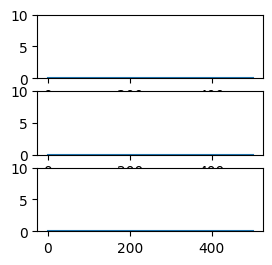

In [391]:
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]])

# Initialize the environment
restart_state = ((0,0), (6,5))
env1 = Maze(maze, False, True, restart_state)

gamma = 0.1
NUM_EPISODES = 500
record_interval = 100

# First part: Solve the problem for two different ε values
EPSILONS = [1, 0.1, 0.01]
V_initial_list = []
labels = []
for i, epsilon in enumerate(EPSILONS):
    Q, V_t = q_learning(env1, gamma, epsilon, NUM_EPISODES, alpha_exponent=2/3)
    print("first round done")
    print(V_t)
    #V_initial_list.append(V_initial)
    #labels.append(f'ε = {epsilon}')
    plt.subplot(5, 2, 2*i + 2)
    plt.ylim(0, 10)
    plt.plot(V_t)
"""
# Plotting the convergence of the value function over episodes
plt.figure()
episodes_axis = np.arange(0, NUM_EPISODES, record_interval)
for i, V_initial in enumerate(V_initial_list):
    plt.plot(episodes_axis[:len(V_initial)], V_initial, label=labels[i])
plt.xlabel('Episodes')
plt.ylabel('Value of Initial State')
plt.title('Convergence of Q-learning with Different ε')
plt.legend()
plt.show()

V, policy = q_learning(env1, gamma, EPSILONS[0], NUM_EPISODES)
print("done first round")
V1, policy1 = q_learning(env1, gamma, EPSILONS[1], NUM_EPISODES)"""

In [364]:
def q_learning(env, gamma, epsilon, episodes, alpha_exponent=2/3):
    """ Solves the maze problem using episodic Q-learning with ε-greedy policy.
        :input Maze env           : The maze environment.
        :input float gamma        : The discount factor.
        :input float epsilon      : Exploration rate for the ε-greedy policy.
        :input int episodes       : Number of episodes to run.
        :return numpy.array Q     : Learned Q-values for state-action pairs.
        :return numpy.array policy: Derived policy from the learned Q-values.
    """
    # Number of states and actions
    n_states = env.n_states
    n_actions = env.n_actions
    #print(env.map())
    state = env.restart_state
    # Initialize Q-values arbitrarily (e.g., zeros)
    Q = np.zeros((n_states, n_actions))
    # Initialize state-action visit counts
    N_sa = np.zeros((n_states, n_actions))
    init_s_index = env.map[state]
    # For storing the policy
    policy = []
    state_index = init_s_index

    # Loop over episodes
    for t in range(episodes):
        # Initialize the environment and get the initial state
        #state = env.reset
        policy.append(np.max(Q[init_s_index, :]))
        #print(env.map[state])
        #print(env.map(state))
        # done = False

        # while not done:
            
        #state_index = env.map(state)
        # Choose action using ε-greedy policy
        action = get_actions(env, state_index, epsilon, Q, False)
        # Take action, observe reward and next state
        next_state_index, reward = env.step(state_index, action)
        #next_state_index = env.map[next_state]
        print("reward: ", reward)
        # Update state-action visit count
        

        # Compute learning rate alpha(s,a)
        alpha = compute_lr(N_sa[state_index, action])
        # alpha = 1 / ((N_sa[state_index, action]) ** (alpha_exponent))
        print("alpha: ", alpha)
        print("Q: ", Q[next_state_index, :])
        best_next_Q = np.max(Q[next_state_index, :])
        print(best_next_Q)
        Q[state_index, action] = (1-alpha)*Q[state_index, action] + alpha*(reward + gamma*best_next_Q)
        
        N_sa[state_index, action] += 1
        """# Update Q-value
        if done:
            Q[state, action] += alpha * (reward - Q[state, action])
        else:
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
"""
        # Move to next state
        state_index = next_state_index

        # Optionally, update policy after each episode
        # for s in range(n_states):
            # policy[s] = np.argmax(Q[s, :])

    # Return the learned Q-values and the derived policy
    return Q, policy